# Синтаксические зависимости в Neo4j

## Структура  

**Ноды:**  
Типы Target - NonTarget  
У каждого нода есть:
* text_id
* sent_id
* word_id
* word
* lemma
* pos
* gram

**Отношения между нодами:**  
Тип отношения - dep, устанавливается с head по head_id

## Подключимся к базе и прочитаем данные

In [3]:
from neo4j import GraphDatabase, RoutingControl

URI = "bolt://localhost:7687"
AUTH = # my password

In [9]:
import pandas as pd

In [22]:
ud = pd.read_csv('UD_full_no_punct.csv').fillna('NaN')

In [23]:
ud.head()

,text_id,sent_id,is_sent_start,word_id,is_target,word,lemma,pos,gram,dep,head,head_id
0,1,1,True,1,0,Пилат,Пилата,NOUN,Animacy=Inan|Case=Nom|Gender=Masc|Number=Sing,nsubj,повернулся,2
1,1,1,False,2,1,повернулся,повернуться,VERB,Aspect=Perf|Gender=Masc|Mood=Ind|Number=Sing|T...,ROOT,повернулся,2
2,1,1,False,3,0,и,и,CCONJ,NaN,cc,пошел,4
3,1,1,False,4,0,пошел,пойти,VERB,Aspect=Perf|Gender=Masc|Mood=Ind|Number=Sing|T...,conj,повернулся,2
4,1,1,False,5,0,по,по,ADP,NaN,case,мосту,6


## Пополнить базу

In [24]:
def add_target(driver, row):
    driver.execute_query(
        "MERGE (a:Target {text_id: $text_id, sent_id: $sent_id, word_id: $word_id, word: $word, lemma: $lemma, pos: $pos, gram: $gram}) ",
        text_id = row.text_id, sent_id = row.sent_id, word_id = row.word_id,
        word = row.word, lemma = row.lemma, pos = row.pos, gram = row.gram, database_="neo4j",
    )

def add_nontarget(driver, row):
    driver.execute_query(
        "MERGE (a:NonTarget {text_id: $text_id, sent_id: $sent_id, word_id: $word_id, word: $word, lemma: $lemma, pos: $pos, gram: $gram}) ",
        text_id = row.text_id, sent_id = row.sent_id, word_id = row.word_id,
        word = row.word, lemma = row.lemma, pos = row.pos, gram = row.gram, database_="neo4j",
    )

In [25]:
for index, row in ud.iterrows():
    with GraphDatabase.driver(URI, auth=AUTH) as driver:
        if row.is_target == 1:
            add_target(driver, row)
        else:
            add_nontarget(driver, row)

In [26]:
def add_dependency(driver, row):
    driver.execute_query(
        "MATCH (a) WHERE a.text_id = $text_id and a.word_id = $word_id "
        "MATCH (b) WHERE b.text_id = $text_id and b.word_id = $head_id "
        "MERGE (b)-[:DEPENDENCY {dep: $dep}]->(a)",
        text_id = row.text_id, word_id = row.word_id, head_id = row.head_id, 
        dep = row.dep, database_="neo4j",
    )

In [27]:
for index, row in ud.iterrows():
    with GraphDatabase.driver(URI, auth=AUTH) as driver:
        add_dependency(driver, row)

## Переразметка

In [32]:
def update_dependency(driver, text_id, word_id, new_head, new_dep):
    driver.execute_query(
        "MATCH (b)-[d]->(a) WHERE a.text_id = $text_id and a.word_id = $word_id "
        "MATCH (c) WHERE c.text_id = $text_id and c.word_id = $new_head "
        "DELETE d "
        "MERGE (c)-[:DEPENDENCY {dep: $new_dep}]->(a)",
        text_id = text_id, word_id = word_id, new_head = new_head, 
        new_dep = new_dep, database_="neo4j",
    )

In [ ]:
with GraphDatabase.driver(URI, auth=AUTH) as driver:
    update_dependency(driver, 5, 126, 125, 'jvdfvkjfdkj')

In [ ]:
with GraphDatabase.driver(URI, auth=AUTH) as driver:
    update_dependency(driver, 5, 126, 127, 'case')

## Удалить что-то из базы

In [7]:
def delete_node(driver, text_id, word_id):
    driver.execute_query(
        "MATCH (a) WHERE a.text_id = $text_id and a.word_id = $word_id "
        "DETACH DELETE (a) ",
        text_id = text_id, word_id = word_id, database_="neo4j",
    )

In [35]:
with GraphDatabase.driver(URI, auth=AUTH) as driver:
    delete_node(driver, 5, 131)

In [21]:
# снести базу целиком (dict_of_stats там ниже получается)

with GraphDatabase.driver(URI, auth=AUTH) as driver:
    for text in dict_of_stats.keys():
        length = dict_of_stats[text]
        for i in range(1, length + 1):
            delete_node(driver, text, i)

## Всякие принты

### Вершины

In [83]:
def print_head(driver, text_id, word_id):
    records, _, _ = driver.execute_query(
        "MATCH (b)-[:DEPENDENCY]->(a) WHERE a.text_id = $text_id and a.word_id = $word_id "
        "RETURN b.word_id",
        text_id = text_id, word_id = word_id, database_="neo4j", routing_=RoutingControl.READ,
    )
    for record in records:
        print(record["b.word_id"])

In [84]:
with GraphDatabase.driver(URI, auth=AUTH) as driver:
    print_head(driver, 5, 300)

298


In [85]:
def print_overhead(driver, text_id, word_id):
    records, _, _ = driver.execute_query(
        "MATCH (b)-[*]->(a) WHERE a.text_id = $text_id and a.word_id = $word_id and b.word_id <> a.word_id "
        "RETURN DISTINCT b.word_id ORDER BY b.word_id",
        text_id = text_id, word_id = word_id, database_="neo4j", routing_=RoutingControl.READ,
    )
    for record in records:
        print(record["b.word_id"])

In [86]:
with GraphDatabase.driver(URI, auth=AUTH) as driver:
    print_overhead(driver, 5, 300)

298
302


### Зависимые

In [28]:
def print_dependents(driver, text_id, word_id):
    records, _, _ = driver.execute_query(
        "MATCH (b)-[:DEPENDENCY]->(a) WHERE b.text_id = $text_id and b.word_id = $word_id "
        "RETURN a.word_id ORDER BY a.word_id",
        text_id = text_id, word_id = word_id, database_="neo4j", routing_=RoutingControl.READ,
    )
    dependents = []
    for record in records:
        dependents.append(record["a.word_id"])
    if len(dependents) > 0:
        return str(dependents)
    else:
        return 'NaN'

In [29]:
with GraphDatabase.driver(URI, auth=AUTH) as driver:
    print(print_dependents(driver, 5, 298))

[295, 296, 297, 300]


In [30]:
def add_column_with_dependents(row):
    with GraphDatabase.driver(URI, auth=AUTH) as driver:
        deps = print_dependents(driver, row.text_id, row.word_id)
        row['dependents'] = deps
    return row

In [31]:
ud = ud.apply(add_column_with_dependents, axis=1)

In [32]:
ud.head()

,text_id,sent_id,is_sent_start,word_id,is_target,word,lemma,pos,gram,dep,head,head_id,dependents
0,1,1,True,1,0,Пилат,Пилата,NOUN,Animacy=Inan|Case=Nom|Gender=Masc|Number=Sing,nsubj,повернулся,2,NaN
1,1,1,False,2,1,повернулся,повернуться,VERB,Aspect=Perf|Gender=Masc|Mood=Ind|Number=Sing|T...,ROOT,повернулся,2,"[1, 2, 4]"
2,1,1,False,3,0,и,и,CCONJ,NaN,cc,пошел,4,NaN
3,1,1,False,4,0,пошел,пойти,VERB,Aspect=Perf|Gender=Masc|Mood=Ind|Number=Sing|T...,conj,повернулся,2,"[3, 6, 7, 9, 12]"
4,1,1,False,5,0,по,по,ADP,NaN,case,мосту,6,NaN


### Количество зависимых

Можно было просто модифицировать предыдущую функцию, чтобы она возвращала не сам список, а его длины. Но сделаем это функцией count внутри neo4j.

In [33]:
def print_count_dependents(driver, text_id, word_id):
    records, _, _ = driver.execute_query(
        "MATCH (b)-[:DEPENDENCY]->(a) WHERE b.text_id = $text_id and b.word_id = $word_id "
        "RETURN COUNT(a) ",
        text_id = text_id, word_id = word_id, database_="neo4j", routing_=RoutingControl.READ,
    )
    for record in records:
        return record["COUNT(a)"]

In [34]:
with GraphDatabase.driver(URI, auth=AUTH) as driver:
    print(print_count_dependents(driver, 5, 298))

4


In [35]:
def add_column_with_count_dependents(row):
    with GraphDatabase.driver(URI, auth=AUTH) as driver:
        deps = print_count_dependents(driver, row.text_id, row.word_id)
        row['count_dependents'] = deps
    return row

In [36]:
ud = ud.apply(add_column_with_count_dependents, axis=1)

In [37]:
ud.head()

,text_id,sent_id,is_sent_start,word_id,is_target,word,lemma,pos,gram,dep,head,head_id,dependents,count_dependents
0,1,1,True,1,0,Пилат,Пилата,NOUN,Animacy=Inan|Case=Nom|Gender=Masc|Number=Sing,nsubj,повернулся,2,NaN,0
1,1,1,False,2,1,повернулся,повернуться,VERB,Aspect=Perf|Gender=Masc|Mood=Ind|Number=Sing|T...,ROOT,повернулся,2,"[1, 2, 4]",3
2,1,1,False,3,0,и,и,CCONJ,NaN,cc,пошел,4,NaN,0
3,1,1,False,4,0,пошел,пойти,VERB,Aspect=Perf|Gender=Masc|Mood=Ind|Number=Sing|T...,conj,повернулся,2,"[3, 6, 7, 9, 12]",5
4,1,1,False,5,0,по,по,ADP,NaN,case,мосту,6,NaN,0


### Найти таргетные слова, у которых есть и вершина (отличная от них самих), и зависимое

In [38]:
def print_middle_targets(driver):
    records, _, _ = driver.execute_query(
        "MATCH (c)-[:DEPENDENCY]->(b:Target)-[:DEPENDENCY]->(a) "
        "WHERE c.word_id <> b.word_id "
        "RETURN DISTINCT b.text_id, b.word_id ",
        database_="neo4j", routing_=RoutingControl.READ,
    )
    list_of_middles = []
    for record in records:
        list_of_middles.append((record["b.text_id"], record["b.word_id"]))
    return list_of_middles

In [39]:
with GraphDatabase.driver(URI, auth=AUTH) as driver:
    list_of_middles = print_middle_targets(driver)

In [40]:
list_of_middles[:5]

[(1, 9), (1, 19), (1, 36), (1, 44), (1, 64)]

In [43]:
def add_column_with_middle_targets(row):
    if row.is_target == 0:
        middle = 0
    else:
        m = (row.text_id, row.word_id)
        if m in list_of_middles:
            middle = 1
        else:
            middle = 0
    row['is_middle'] = middle
    return row

In [44]:
ud = ud.apply(add_column_with_middle_targets, axis=1)

In [45]:
ud.head(10)

,text_id,sent_id,is_sent_start,word_id,is_target,word,lemma,pos,gram,dep,head,head_id,dependents,count_dependents,is_middle
0,1,1,True,1,0,Пилат,Пилата,NOUN,Animacy=Inan|Case=Nom|Gender=Masc|Number=Sing,nsubj,повернулся,2,NaN,0,0
1,1,1,False,2,1,повернулся,повернуться,VERB,Aspect=Perf|Gender=Masc|Mood=Ind|Number=Sing|T...,ROOT,повернулся,2,"[1, 2, 4]",3,0
2,1,1,False,3,0,и,и,CCONJ,NaN,cc,пошел,4,NaN,0,0
3,1,1,False,4,0,пошел,пойти,VERB,Aspect=Perf|Gender=Masc|Mood=Ind|Number=Sing|T...,conj,повернулся,2,"[3, 6, 7, 9, 12]",5,0
4,1,1,False,5,0,по,по,ADP,NaN,case,мосту,6,NaN,0,0
5,1,1,False,6,0,мосту,мост,NOUN,Animacy=Inan|Case=Dat|Gender=Masc|Number=Sing,obl,пошел,4,[5],1,0
6,1,1,False,7,0,назад,назад,ADV,Degree=Pos,advmod,пошел,4,NaN,0,0
7,1,1,False,8,0,к,к,ADP,NaN,case,ступеням,9,NaN,0,0
8,1,1,False,9,1,ступеням,ступень,NOUN,Animacy=Inan|Case=Dat|Gender=Fem|Number=Plur,obl,пошел,4,[8],1,1
9,1,1,False,11,0,не,не,PART,NaN,advmod,глядя,12,NaN,0,0


In [46]:
ud.to_csv('UD_full_extended.csv', index=False)

**Интересный итог:** Слова, у которых есть и вершина, отличная от них самих, и зависимое (хотя бы одно), предсказываются лучше, чем слова, у которых чего-то из этого нет (p-value = 0.05691 по t-тесту).

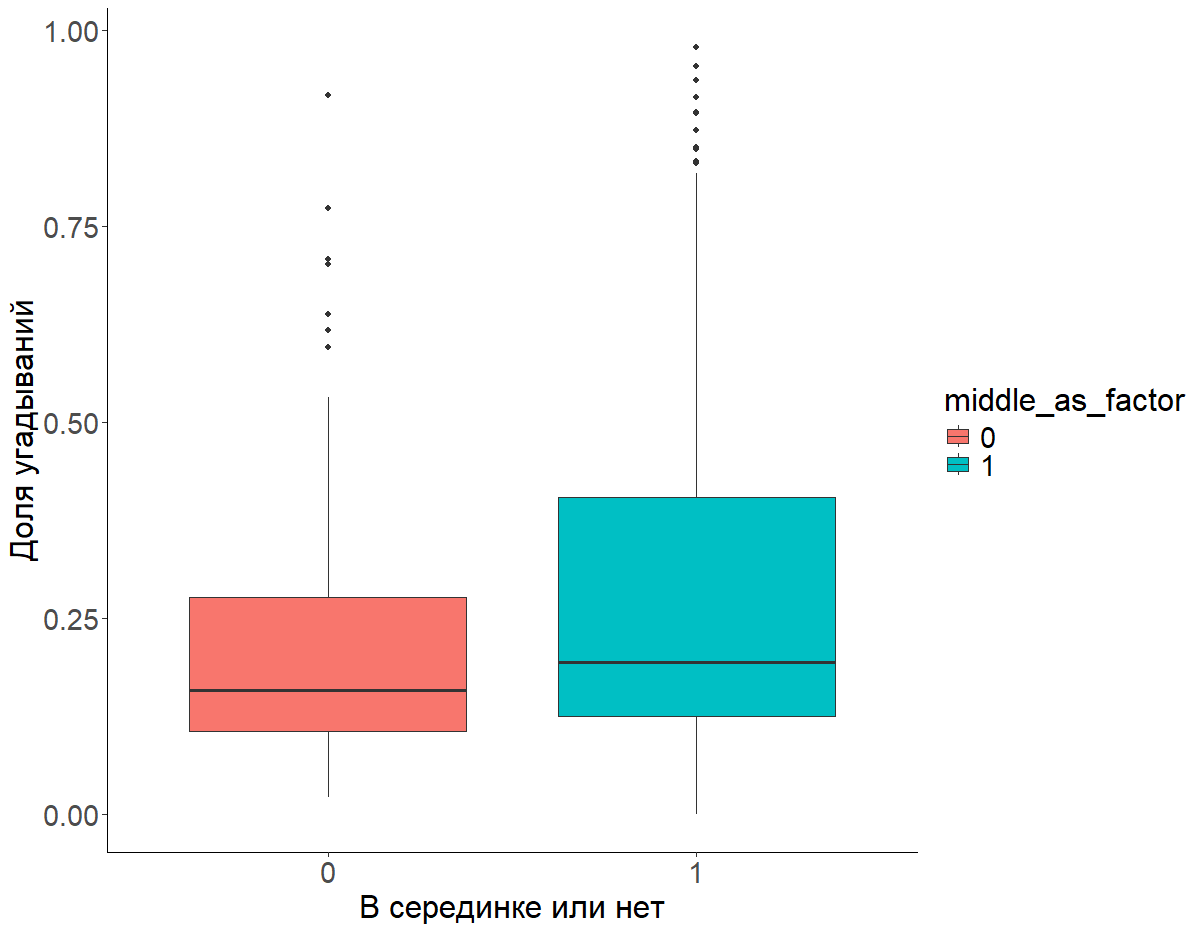

### Статистика по частям речи

In [89]:
def print_most_common_heads(driver, pos):
    records, _, _ = driver.execute_query(
        "MATCH (b)-[:DEPENDENCY]->(a) WHERE a.pos = $pos "
        "RETURN b.pos, COUNT(*)",
        pos = pos, database_="neo4j", routing_=RoutingControl.READ,
    )
    for record in records:
        print(record["b.pos"], record["COUNT(*)"])

In [90]:
with GraphDatabase.driver(URI, auth=AUTH) as driver:
    print_most_common_heads(driver, 'NOUN')

VERB 312
PRON 10
NOUN 124
NUM 1
ADJ 20
PROPN 8
ADP 2
ADV 4
DET 1
PART 1


In [126]:
def print_average_dependents(driver, pos):
    records, _, _ = driver.execute_query(
        "MATCH (a) WHERE a.pos = $pos "
        "MATCH (c)-[:DEPENDENCY]->(b) WHERE c.pos = $pos "
        "RETURN COUNT(DISTINCT b), COUNT(DISTINCT a)",
        pos = pos, database_="neo4j", routing_=RoutingControl.READ,
    )
    for record in records:
        print(record["COUNT(DISTINCT b)"] / record["COUNT(DISTINCT a)"])

In [127]:
with GraphDatabase.driver(URI, auth=AUTH) as driver:
    print_average_dependents(driver, 'NOUN')

1.546583850931677


In [128]:
with GraphDatabase.driver(URI, auth=AUTH) as driver:
    print_average_dependents(driver, 'VERB')

3.7103960396039604


Если исключить все зависимости "в себя" (которые есть у ROOT-ов):

In [129]:
def print_average_dependents_2(driver, pos):
    records, _, _ = driver.execute_query(
        "MATCH (a) WHERE a.pos = $pos "
        "MATCH (c)-[:DEPENDENCY]->(b) WHERE c.pos = $pos and c.word_id <> b.word_id "
        "RETURN COUNT(DISTINCT b), COUNT(DISTINCT a)",
        pos = pos, database_="neo4j", routing_=RoutingControl.READ,
    )
    for record in records:
        print(record["COUNT(DISTINCT b)"] / record["COUNT(DISTINCT a)"])

In [130]:
with GraphDatabase.driver(URI, auth=AUTH) as driver:
    print_average_dependents_2(driver, 'VERB')

3.4603960396039604


## Алгосы

https://data-xtractor.com/blog/graphs/neo4j-graph-algorithms-community-detection/

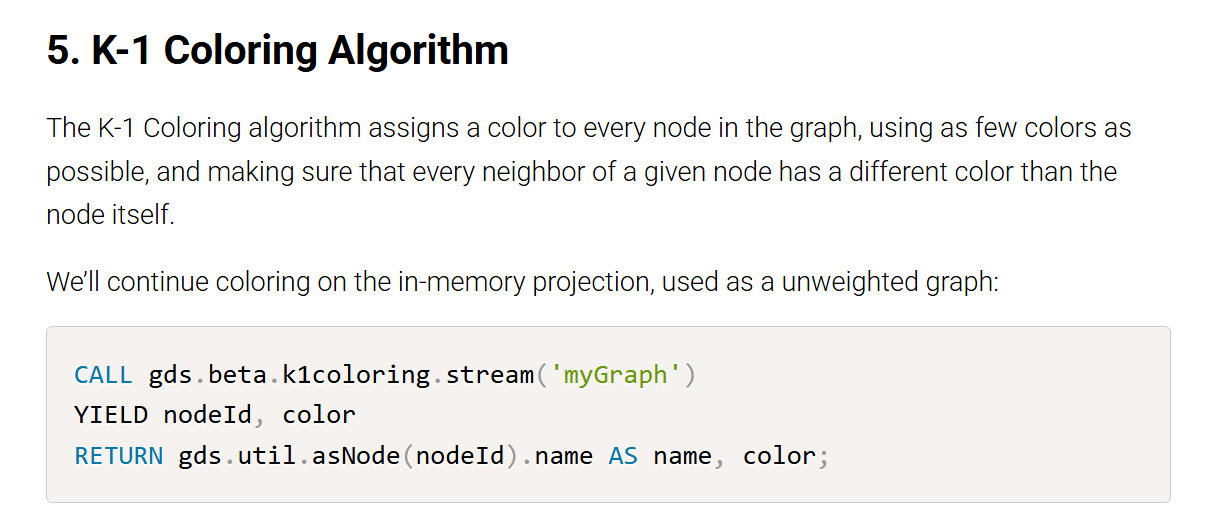
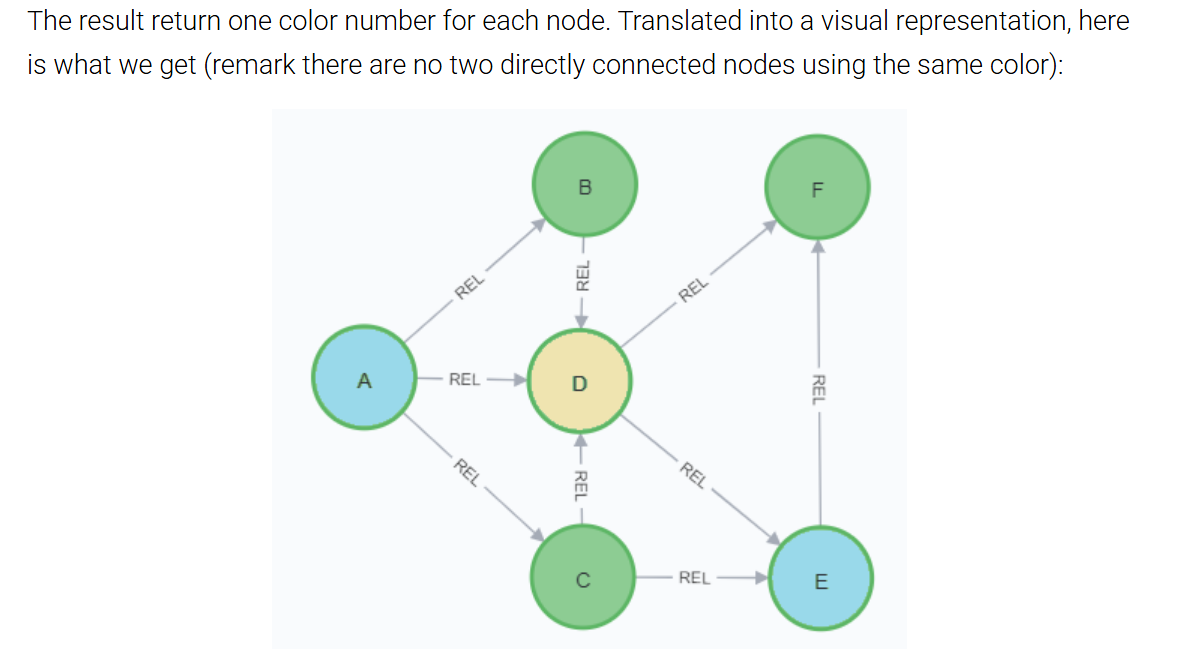

### Найти и подсчитать подграфы

In [2]:
def print_subgraph(driver, text_id, word_id):
    records, _, _ = driver.execute_query(
        "MATCH (b)-[*]-(a) WHERE a.text_id = $text_id and a.word_id = $word_id "
        "RETURN DISTINCT b.word_id ORDER BY b.word_id ",
        text_id = text_id, word_id = word_id, database_="neo4j", routing_=RoutingControl.READ,
    )
    sub_graph_members = []
    for record in records:
        sub_graph_members.append(record["b.word_id"])
        sub_graph_members.append(word_id)
    return sorted(list(set(sub_graph_members)))

In [4]:
def print_stats(driver):
    records, _, _ = driver.execute_query(
        "MATCH (a) "
        "RETURN DISTINCT a.text_id, COUNT(a)",
        database_="neo4j", routing_=RoutingControl.READ,
    )
    dict_of_stats = {}
    for record in records:
        dict_of_stats[record["a.text_id"]] = record["COUNT(a)"]
    return dict_of_stats

In [5]:
with GraphDatabase.driver(URI, auth=AUTH) as driver:
    dict_of_stats = print_stats(driver)

In [6]:
dict_of_stats

{1: 474, 2: 474, 3: 346, 4: 491, 5: 463, 6: 438}

In [6]:
with GraphDatabase.driver(URI, auth=AUTH) as driver:
    dict_of_subgraphs = {}
    total_number_of_subgraphs = 0
    for text in dict_of_stats.keys():
        length = dict_of_stats[text]
        all_subgraphs_for_text = []
        for i in range(1, length + 1):
            new_subgraph = print_subgraph(driver, text, i)
            if new_subgraph not in all_subgraphs_for_text:
                all_subgraphs_for_text.append(new_subgraph)
        dict_of_subgraphs[text] = all_subgraphs_for_text
        total_number_of_subgraphs += len(all_subgraphs_for_text)

In [7]:
total_number_of_subgraphs

117

In [8]:
print(dict_of_subgraphs[1][0])

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]


### Раскраски (алгоритм нормально работает кажется только на деревьях...)

In [9]:
def color_first_node(driver, text_id, word_id):
    driver.execute_query(
        "MATCH (a) WHERE a.text_id = $text_id and a.word_id = $word_id "
        "SET a.color = 1 ",
        text_id = text_id, word_id = word_id, database_="neo4j",
    )

In [20]:
def find_neighbours(driver, text_id, word_id):
    records, _, _ = driver.execute_query(
        "MATCH (b)-[]-(a) WHERE a.text_id = $text_id and a.word_id = $word_id and a.word_id <> b.word_id "
        "RETURN DISTINCT b.word_id ",
        text_id = text_id, word_id = word_id, database_="neo4j", routing_=RoutingControl.READ,
    )
    neighbours = []
    for record in records:
        neighbours.append(record["b.word_id"])
    return neighbours

In [22]:
def find_inappropriate_colors(driver, text_id, word_id):
    records, _, _ = driver.execute_query(
        "MATCH (b)-[]-(a) WHERE a.text_id = $text_id and a.word_id = $word_id and a.word_id <> b.word_id "
        "RETURN DISTINCT b.color ",
        text_id = text_id, word_id = word_id, database_="neo4j", routing_=RoutingControl.READ,
    )
    colors = []
    for record in records:
        colors.append(record["b.color"])
    return colors

In [12]:
def color_another_node(driver, text_id, word_id, color):
    driver.execute_query(
        "MATCH (a) WHERE a.text_id = $text_id and a.word_id = $word_id "
        "SET a.color = $color ",
        text_id = text_id, word_id = word_id, color = color, database_="neo4j",
    )

In [25]:
def color_subgraph(text, sentence):
    with GraphDatabase.driver(URI, auth=AUTH) as driver:
        ind = sentence - 1
        nodes = dict_of_subgraphs[text][ind]
        length = len(nodes)
        colored = []
        color_first_node(driver, text, nodes[0])
        colored.append(nodes[0])
        j = 1
        neighbours = find_neighbours(driver, text, nodes[0])
        while j <= length:
            new_neighbours = []
            for neighbour in neighbours:
                if neighbour not in colored:
                    inappropriate = find_inappropriate_colors(driver, text, neighbour)
                    new_color = 1
                    i = 1
                    while i <= length:
                        if new_color in inappropriate:
                            new_color += 1
                        i += 1
                    color_another_node(driver, text, neighbour, new_color)
                    colored.append(neighbour)
                    new = find_neighbours(driver, text, neighbour)
                    new_neighbours.extend(new)
            neighbours = new_neighbours
            j += 1

In [36]:
color_subgraph(1, 5)

In [28]:
def find_chrom_number_of_subgraph(driver, text_id, sent_id):
    records, _, _ = driver.execute_query(
        "MATCH (a) WHERE a.text_id = $text_id and a.sent_id = $sent_id "
        "RETURN COUNT(DISTINCT a.color) ",
        text_id = text_id, sent_id = sent_id, database_="neo4j", routing_=RoutingControl.READ,
    )
    for record in records:
        print(record["COUNT(DISTINCT a.color)"])

In [29]:
with GraphDatabase.driver(URI, auth=AUTH) as driver:
    find_chrom_number_of_subgraph(driver, 1, 5)

2


In [37]:
for text in dict_of_subgraphs.keys():
    num_of_sentences = len(dict_of_subgraphs[text])
    for i in range(1, num_of_sentences + 1):
        color_subgraph(text, i)

In [40]:
def find_chrom_number(driver):
    records, _, _ = driver.execute_query(
        "MATCH (a) "
        "RETURN COUNT(DISTINCT a.color) ",
        database_="neo4j", routing_=RoutingControl.READ,
    )
    for record in records:
        print(record["COUNT(DISTINCT a.color)"])

In [41]:
with GraphDatabase.driver(URI, auth=AUTH) as driver:
    find_chrom_number(driver)

2
